In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/BTC-USD.csv')
df1=df.reset_index()['Close']

In [3]:
# Loại bỏ các trường không cần thiết
df = df.drop(columns = ['Adj Close'])
df.head()

,Date,Open,High,Low,Close,Volume
0,2017-12-01,10198.599609,11046.700195,9694.650391,10975.599609,6783119872
1,2017-12-02,10978.299805,11320.200195,10905.099609,11074.599609,5138500096
2,2017-12-03,11082.700195,11858.700195,10862.000000,11323.200195,6608309760
3,2017-12-04,11315.400391,11657.200195,11081.799805,11657.200195,6132409856
4,2017-12-05,11685.700195,12032.000000,11604.599609,11916.700195,6895260160


In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [25]:
# 4.1 Chia train test tỉ lệ
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
train_size

1358

In [ ]:
train_data

array([[0.16198395],
       [0.18257929],
       [0.18598206],
       ...,
       [0.68445068],
       [0.70016408],
       [0.68433719]])

In [ ]:
train_size

1164

In [ ]:
train_data

array([[0.16198395],
       [0.18257929],
       [0.18598206],
       ...,
       [0.74568444],
       [0.76184846],
       [0.80191671]])

In [26]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [27]:
#6.1 Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [19]:
# 7.1 Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [28]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [29]:
# 9.1 Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 2s 53ms/step - loss: 0.0095 - val_loss: 0.5422
Epoch 2/100
15/15 [==============================] - 0s 31ms/step - loss: 0.0013 - val_loss: 0.3238
Epoch 3/100
15/15 [==============================] - 0s 27ms/step - loss: 6.3557e-04 - val_loss: 0.1967
Epoch 4/100
15/15 [==============================] - 0s 29ms/step - loss: 4.7305e-04 - val_loss: 0.1606
Epoch 5/100
15/15 [==============================] - 1s 34ms/step - loss: 4.0354e-04 - val_loss: 0.1613
Epoch 6/100
15/15 [==============================] - 1s 35ms/step - loss: 3.5137e-04 - val_loss: 0.1471
Epoch 7/100
15/15 [==============================] - 0s 28ms/step - loss: 3.2374e-04 - val_loss: 0.1284
Epoch 8/100
15/15 [==============================] - 1s 35ms/step - loss: 3.0213e-04 - val_loss: 0.1130
Epoch 9/100
15/15 [==============================] - 0s 33ms/step - loss: 3.0268e-04 - val_loss: 0.1039
Epoch 10/100
15/15 [==============================] - 0s 30ms/step - los

In [30]:
# 10.1 Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

10/10 [==============================] - 0s 12ms/step


In [31]:
# 11.1 Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [32]:
# 13.1 Đánh giá mô hình trên tập test (5:3:2)
from sklearn.metrics import r2_score
from sklearn import metrics

# 1. mse:tổng bình phương sai số trên tập mẫu (Giá trị MSE càng nhỏ, mô hình dự báo càng chính xác.)
mse = metrics.mean_squared_error(ytest,y_pred)

# 2. rmse: căn của tổng bình phương sai số trên tập mẫu,được sử dụng để đánh giá sai số trung bình giữa giá trị dự báo và giá trị thực tế
#(giá trị này càng nhỏ thì mô hình càng chính xác)
rmse = np.sqrt(mse)

# 3. mae : trị tuyệt đối trung bình(giá trị này càng nhỏ thì mô hình càng chính xác)
mae = metrics.mean_absolute_error(ytest,y_pred)

#4. mape : tính toán độ sai lệch trung bình giữa các giá trị dự đoán và giá trị thực tế dưới dạng phần trăm(Giá trị MAPE càng nhỏ thì độ chính xác của mô hình càng cao)
#  mô hình có MAPE dưới 10% được xem là rất tốt
mape = metrics.mean_absolute_percentage_error(ytest, y_pred)

print('MSE: ' , mse)
print('RMSE: ' , rmse)
print('MAE: ' , mae)
print('MAPE: ', mape * 100)

MSE:  1787579767.5576365
RMSE:  42279.7796536079
MAE:  41597.23751097618
MAPE:  6457462.131637779


In [13]:
# 13.1 Đánh giá mô hình trên tập test (7:2:1)
from sklearn.metrics import r2_score
from sklearn import metrics

# 1. mse:tổng bình phương sai số trên tập mẫu (Giá trị MSE càng nhỏ, mô hình dự báo càng chính xác.)
mse = metrics.mean_squared_error(ytest,y_pred)

# 2. rmse: căn của tổng bình phương sai số trên tập mẫu,được sử dụng để đánh giá sai số trung bình giữa giá trị dự báo và giá trị thực tế
#(giá trị này càng nhỏ thì mô hình càng chính xác)
rmse = np.sqrt(mse)

# 3. mae : trị tuyệt đối trung bình(giá trị này càng nhỏ thì mô hình càng chính xác)
mae = metrics.mean_absolute_error(ytest,y_pred)

#4. mape : tính toán độ sai lệch trung bình giữa các giá trị dự đoán và giá trị thực tế dưới dạng phần trăm(Giá trị MAPE càng nhỏ thì độ chính xác của mô hình càng cao)
#  mô hình có MAPE dưới 10% được xem là rất tốt
mape = metrics.mean_absolute_percentage_error(ytest, y_pred)

print('MSE: ' , mse)
print('RMSE: ' , rmse)
print('MAE: ' , mae)
print('MAPE: ', mape * 100)

MSE:  938944328.0905914
RMSE:  30642.198486573892
MAE:  29069.742616196418
MAPE:  7538484.229275908


In [24]:
# 13.1 Đánh giá mô hình trên tập test (6:2:2)
from sklearn.metrics import r2_score
from sklearn import metrics

# 1. mse:tổng bình phương sai số trên tập mẫu (Giá trị MSE càng nhỏ, mô hình dự báo càng chính xác.)
mse = metrics.mean_squared_error(ytest,y_pred)

# 2. rmse: căn của tổng bình phương sai số trên tập mẫu,được sử dụng để đánh giá sai số trung bình giữa giá trị dự báo và giá trị thực tế
#(giá trị này càng nhỏ thì mô hình càng chính xác)
rmse = np.sqrt(mse)

# 3. mae : trị tuyệt đối trung bình(giá trị này càng nhỏ thì mô hình càng chính xác)
mae = metrics.mean_absolute_error(ytest,y_pred)

#4. mape : tính toán độ sai lệch trung bình giữa các giá trị dự đoán và giá trị thực tế dưới dạng phần trăm(Giá trị MAPE càng nhỏ thì độ chính xác của mô hình càng cao)
#  mô hình có MAPE dưới 10% được xem là rất tốt
mape = metrics.mean_absolute_percentage_error(ytest, y_pred)

print('MSE: ' , mse)
print('RMSE: ' , rmse)
print('MAE: ' , mae)
print('MAPE: ', mape * 100)

MSE:  2330521374.7777376
RMSE:  48275.47384311973
MAE:  47775.012518688476
MAPE:  7250867.611966411


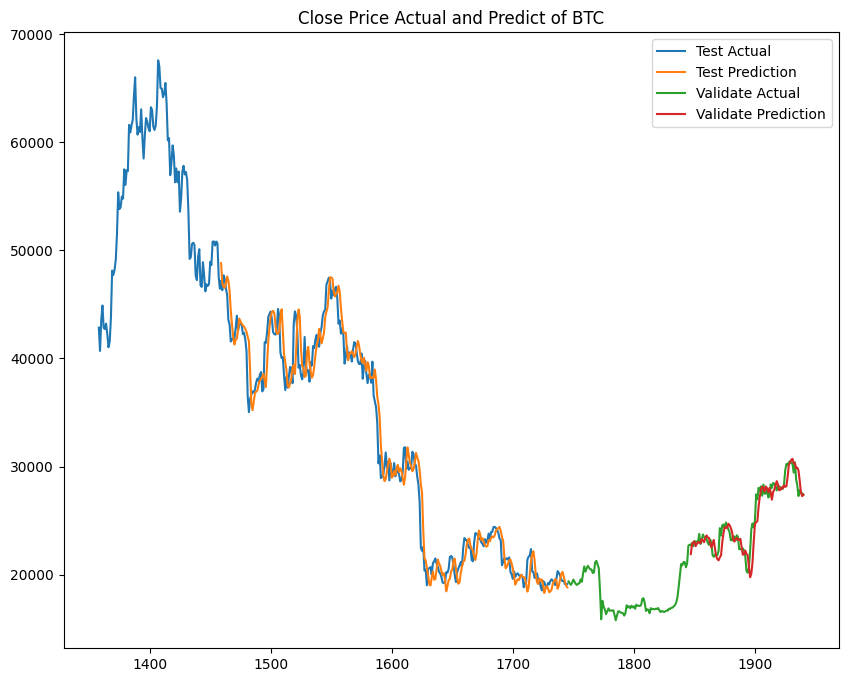

In [ ]:
#14.1. So sánh giá Close thực tế và dự đoán (7:2:1)
plt.figure(figsize=(10,8))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data), label = 'Test Actual')
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred), label = 'Test Prediction')
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data), label = 'Validate Actual')
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val, label = 'Validate Prediction')
plt.title('Close Price Actual and Predict of BTC')
plt.legend()
plt.show()

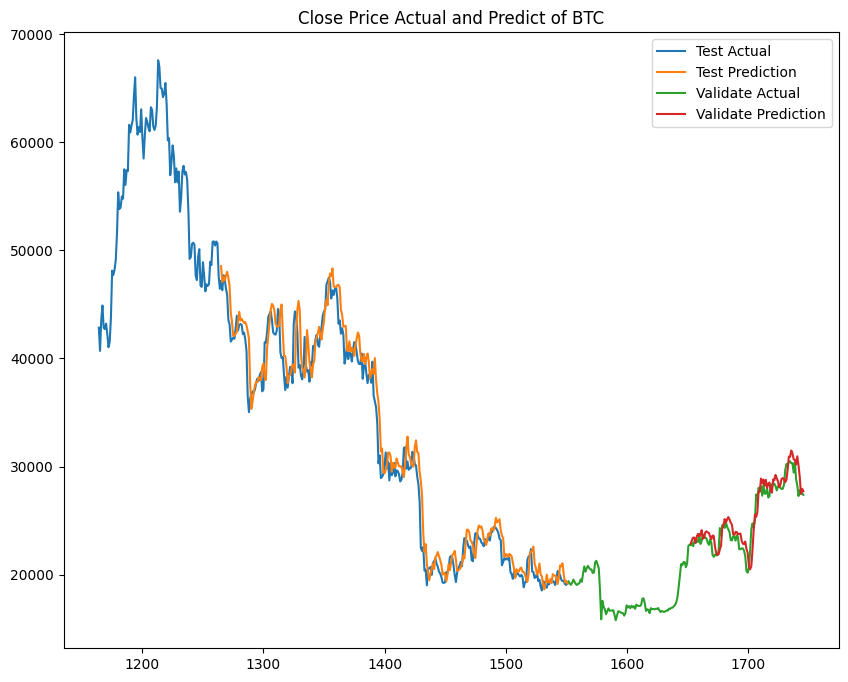

In [ ]:
#14.1. So sánh giá Close thực tế và dự đoán (6:2:2)
plt.figure(figsize=(10,8))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data), label = 'Test Actual')
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred), label = 'Test Prediction')
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data), label = 'Validate Actual')
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val, label = 'Validate Prediction')
plt.title('Close Price Actual and Predict of BTC')
plt.legend()
plt.show()

In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=134
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()